# Finding correlated mutations in development of brain lower grade glioma

Documentation: 
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variant_grouping
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.most_common_variants
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.annotate

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements

Try this demo online: https://colab.research.google.com/drive/1y5HuyObECCp25ZsNUNzL3UshMPCnEl-T?usp=sharing

### Premise:
Usually tumor development is never associated to a single wrong nucleotide or short sequence, moreover our cells are capable to repair themselves when an error is found along the long sequence of 3 billion nucleotide pairs. However this sophisticated mechanism can fail if the mutations accumulate. Indeed genetic pathologies are mostly caused by a combination of factors that usually involve many genes containing errors. Starting from this assumption, we can try to identify two mutations that are likely involved in development of brain lower grade glioma.

Useful functions

In [24]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body

## Finding the first "target mutation"

Let's start this research by finding the somatic mutations that are more frequent in cancer patients. 

In [25]:
most_common_mutations_req = {
    'having_meta': {
        'assembly': 'grch38',
        'healthy': false,
        'disease': 'brain lower grade glioma'
    },
    'having_variants': {
        'in_cell_type': ['somatic']
    }
}
most_common_mutations_resp = post_request('http://geco.deib.polimi.it/popstudy/api/most_common_variants', most_common_mutations_req, print_status_code=False, print_warnings=False)

In [26]:
most_common_mutations_resp_df = pd.DataFrame.from_records(most_common_mutations_resp['rows'], columns=most_common_mutations_resp['columns'])
# Let's show also the "POSITIVE_RATIO", i.e. the % of positive donors in the population
most_common_mutations_resp_df['POSITIVE_RATIO'] = most_common_mutations_resp_df.apply(lambda r: r['POSITIVE_DONORS']/r['POPULATION_SIZE'], axis=1)
most_common_mutations_resp_df

,CHROM,START,REF,ALT,POPULATION_SIZE,POSITIVE_DONORS,OCCURRENCE_OF_VARIANT,FREQUENCY_OF_VARIANT,POSITIVE_RATIO
0,2,208248387,C,T,509,354,354,0.347741,0.695481
1,17,7673802,G,A,509,41,62,0.060904,0.080550
2,2,208248388,G,A,509,17,17,0.016699,0.033399
3,17,7674871,T,C,509,8,14,0.013752,0.015717
4,17,7673801,C,T,509,10,14,0.013752,0.019646
5,15,90088605,C,T,509,12,12,0.011788,0.023576
6,17,7675075,T,C,509,7,11,0.010806,0.013752
7,19,42287604,C,T,509,10,11,0.010806,0.019646
8,17,7675087,C,T,509,8,10,0.009823,0.015717
9,2,208248388,G,C,509,10,10,0.009823,0.019646


## "Target mutation 1" or TM1: 2:208248387-C-T (heterozygous)
### It appears only in heterozygous form in 69.5% of patients with brain lower grade glioma.

Let's find out in which group of donors (according to ethnicity and gender) TM1 is more frequent, independently from the tumor type.
    # query

In [27]:
mut_1_req = {
    'having_meta': {
        'assembly': 'grch38',
        'healthy': false
    },
    'having_variants': {
        'in_cell_type': ['somatic']
    },
    "target_variant": {"chrom":2, "start": 208248387, "ref":"C", "alt":"T"},
    "group_by": ["ethnicity", "gender"]
}
mut_1_req_resp = post_request('http://geco.deib.polimi.it/popstudy/api/variant_grouping', mut_1_req, print_status_code=False, print_warnings=False)

    # import as DataFrame

In [28]:
mut_1_req_resp_df = pd.DataFrame.from_records(mut_1_req_resp['rows'], columns=mut_1_req_resp['columns'])
mut_1_req_resp_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''
mut_1_req_resp_df['POSITIVE_RATIO'] = mut_1_req_resp_df.apply(lambda r: r['POSITIVE_DONORS']/r['POPULATION_SIZE'], axis=1)

df0 = mut_1_req_resp_df.pivot_table(mut_1_req_resp_df, ['ETHNICITY', 'GENDER'])

    # plot the ratio of patients with TM1 by ethnicity and gender

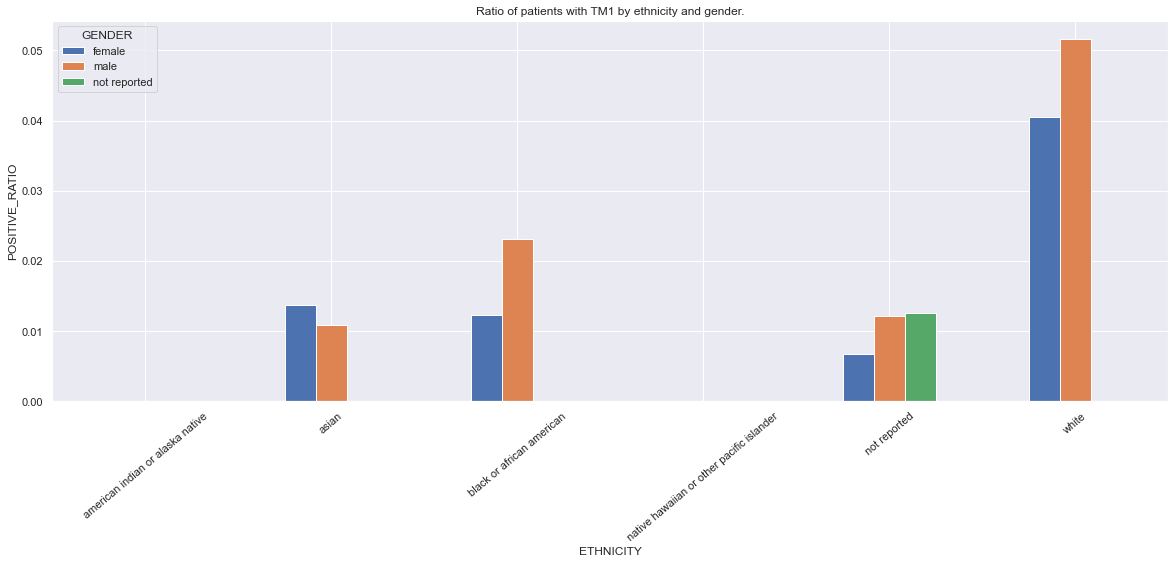

FREQUENCY  \
ETHNICITY                                 GENDER                    
                                                         0.018798   
                                          female         0.016382   
                                          male           0.021579   
                                          not reported   0.006329   
american indian or alaska native                         0.000000   
                                          female         0.000000   
                                          male           0.000000   
asian                                                    0.006079   
                                          female         0.006873   
                                          male           0.005450   
black or african american                                0.008188   
                                          female         0.006130   
                                          male           0.011594   
native hawaiian or other pacific islander                0.000000   
                                          female         0.000000   
                                          male           0.000000   
not reported                                             0.004797   
                                          female         0.003348   
                                          male           0.006083   
                                          not reported   0.006329   
white                                                    0.022980   
                                          female         0.020232   
                                          male           0.025818   

                                                        OCCURRENCE_OF_TARGET_VARIANT  \
ETHNICITY                                 GENDER                                       
                                                                                 383   
                                          female                                 171   
                                          male                                   211   
                                          not reported                             1   
american indian or alaska native                                                   0   
                                          female                                   0   
                                          male                                     0   
asian                                                                              8   
                                          female                                   4   
                                          male                                     4   
black or african american                                                         15   
                                          female                                   7   
                                          male                                     8   
native hawaiian or other pacific islander                                          0   
                                          female                                   0   
                                          male                                     0   
not reported                                                                       9   
                                          female                                   3   
                                          male                                     5   
                                          not reported                             1   
white                                                                            351   
                                          female                                 157   
                                          male                                   194   

                                                        POPULATION_SIZE  \
ETHNICITY                                 GENDER      

In [29]:
df1 = mut_1_req_resp_df.drop(mut_1_req_resp_df.query('GENDER == "" | ETHNICITY == ""').index) # drop aggregated values
df1.drop(['OCCURRENCE_OF_TARGET_VARIANT', 'POPULATION_SIZE', 'POSITIVE_DONORS', 'FREQUENCY'], inplace=True, axis=1) # drop other columns
plot = pd.pivot_table(df1, index='ETHNICITY', columns='GENDER', values='POSITIVE_RATIO').plot(
    kind='bar',
    figsize=(20, 7),
    legend=True
)
for item in plot.get_xticklabels():
     item.set_rotation(40)
plt.title('Ratio of patients with TM1 by ethnicity and gender.')
plt.ylabel('POSITIVE_RATIO')
plt.show()
df0

## The above plot tells the TM1 is peculiar to the white ethnicity, mostly males, and that its frequency is more than double of that of any other ethnic group.

We can just assume that this result refelcts a combination of environmental conditions increasing the occurrence of this tumor type and of genetic predisposition.

## Finding the "target mutation 2" or TM2 

To find the TM2, we can rely on the possibility to restrict the population of interest through metadata and region constraints, by imposing the presence of the TM1 in the ethnic group white.

In [30]:
target_mut_2_req = {
    'having_meta': {
        'assembly': 'grch38',
        'healthy': false,
        "ethnicity": ["white"],
        'disease': 'brain lower grade glioma'
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        "with": [{                  # impose presence of TM1 in patients
            "chrom":2, "start": 208248387, "ref":"C", "alt":"T"
        }]
    }
}
target_mut_2_resp = post_request('http://geco.deib.polimi.it/popstudy/api/most_common_variants', target_mut_2_req, print_status_code=False, print_warnings=False)

In [31]:
target_mut_2_resp_df = pd.DataFrame.from_records(target_mut_2_resp['rows'], columns=target_mut_2_resp['columns'])
target_mut_2_resp_df['POSITIVE_RATIO'] = target_mut_2_resp_df.apply(lambda r: r['POSITIVE_DONORS']/r['POPULATION_SIZE'], axis=1)
target_mut_2_resp_df

,CHROM,START,REF,ALT,POPULATION_SIZE,POSITIVE_DONORS,OCCURRENCE_OF_VARIANT,FREQUENCY_OF_VARIANT,POSITIVE_RATIO
0,2,208248387,C,T,329,329,329,0.500000,1.000000
1,17,7673802,G,A,329,33,51,0.077508,0.100304
2,17,7673801,C,T,329,9,13,0.019757,0.027356
3,17,7674871,T,C,329,7,12,0.018237,0.021277
4,23,77654138,G,A,329,6,6,0.012579,0.018237
5,9,136518617,AGA,,329,8,8,0.012158,0.024316
6,17,7674219,C,T,329,7,8,0.012158,0.021277
7,17,7675075,T,C,329,5,8,0.012158,0.015198
8,24,5737916,C,T,329,1,2,0.011050,0.003040
9,19,42287604,C,T,329,7,7,0.010638,0.021277


## TM2: 17:7673802-G-A (mainly homozygous). Present in 10% of white patients with TM1 and brain lower grade glioma.

But what about the opposite direction, i.e. TM2->TM1 ? We can check it by querying the variant distribution of TM1 in patients where TM2 is present.

In [32]:
freq_distr_of_1_when_2_req = {
    'having_meta': {
        'assembly': 'grch38',
        'healthy': false,
        'disease': 'brain lower grade glioma',
        "ethnicity": ["white"]
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        "with": [{"chrom":17, "start": 7673802, "ref":"G", "alt":"A"}]
    },
    "target_variant": {"chrom":2, "start": 208248387, "ref":"C", "alt":"T"},
    "group_by": ["gender"]
}
freq_distr_of_1_when_2_res = post_request('http://geco.deib.polimi.it/popstudy/api/variant_grouping', freq_distr_of_1_when_2_req, print_status_code=False, print_warnings=False)

In [33]:
freq_distr_of_1_when_2_res_df = pd.DataFrame.from_records(freq_distr_of_1_when_2_res['rows'], columns=freq_distr_of_1_when_2_res['columns'])
freq_distr_of_1_when_2_res_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df20 = freq_distr_of_1_when_2_res_df.pivot_table(freq_distr_of_1_when_2_res_df, ['GENDER'])
df20['POSITIVE_RATIO'] = df20.apply(lambda r: r['POSITIVE_DONORS']/r['POPULATION_SIZE'], axis=1)
df20

,FREQUENCY,OCCURRENCE_OF_TARGET_VARIANT,POPULATION_SIZE,POSITIVE_DONORS,POSITIVE_RATIO
GENDER,,,,,
,0.402439,33,41,33,0.804878
female,0.431818,19,22,19,0.863636
male,0.368421,14,19,14,0.736842


### Interestingly, the observation of TM1 in a patient having TM2 and brain glioma is much more likely than the inverse. 
## Unidirectional linkage: ⁓80% of white patients with brain glioma and carrying TM2 also have TM1. 

## How about other ethnic groups ? 
One may wonder if the same linkage is present also in ethnic groups other than white, in other diseases and if it is equally present between genders.
    # query

In [34]:
# We can obtain the request parameter by modifying accordingly a copy of freq_distr_of_1_when_2_req
freq_distr_of_1_when_2_req_new = freq_distr_of_1_when_2_req.copy()
del freq_distr_of_1_when_2_req_new["having_meta"]["ethnicity"]              # remove filter on ethnicity
del freq_distr_of_1_when_2_req_new["having_meta"]["disease"]                # remove filter on disease
freq_distr_of_1_when_2_req_new["group_by"] = ["ethnicity", "gender"]   # replace dimensions

freq_distr_of_1_when_2_res_new = post_request('http://geco.deib.polimi.it/popstudy/api/variant_grouping', freq_distr_of_1_when_2_req_new, print_status_code=False, print_warnings=False)

    # import as DataFrame

In [35]:
freq_distr_of_1_when_2_res_new_df = pd.DataFrame.from_records(freq_distr_of_1_when_2_res_new['rows'], columns=freq_distr_of_1_when_2_res_new['columns'])
freq_distr_of_1_when_2_res_new_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df30 = freq_distr_of_1_when_2_res_new_df.pivot_table(freq_distr_of_1_when_2_res_new_df, ['ETHNICITY', 'GENDER'])

    # plot frequency of TM1 when TM2 is present in patients by ethnicity and gender

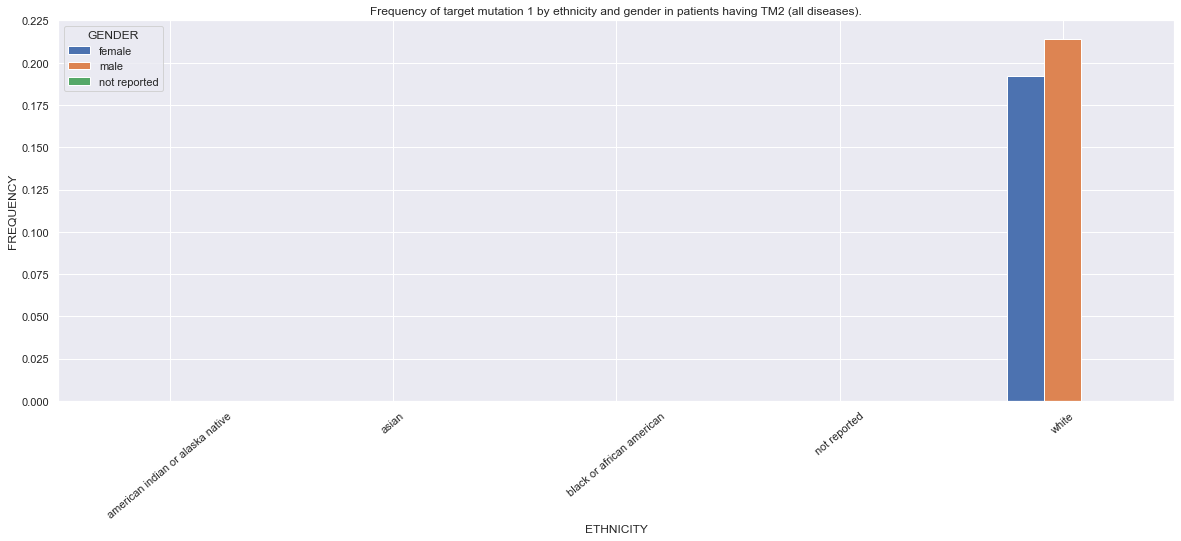

In [36]:
df31 = freq_distr_of_1_when_2_res_new_df.drop(freq_distr_of_1_when_2_res_new_df.query('GENDER == "" | ETHNICITY == ""').index) # drop aggregated values
df31.drop(['OCCURRENCE_OF_TARGET_VARIANT', 'POPULATION_SIZE', 'POSITIVE_DONORS'], inplace=True, axis=1) # drop other columns
plot = pd.pivot_table(df31, index='ETHNICITY', columns='GENDER', values='FREQUENCY').plot(
    kind='bar',
    figsize=(20, 7),
    legend=True
)
for item in plot.get_xticklabels():
     item.set_rotation(40)
plt.title('Frequency of target mutation 1 by ethnicity and gender in patients having TM2 (all diseases).')
plt.ylabel('FREQUENCY')
plt.show()

### This result indicates that the linkage is basically absent in all the other ethnic groups and gender combinations. Indeed, by observing the table, we can see that TM2 is almost absent (POPULATION_SIZE ≤ 6) in other ethnic groups and TM1 is completely absent in those individuals.

In [37]:
df30

FREQUENCY  \
ETHNICITY                        GENDER                    
                                                0.176768   
                                 female         0.169492   
                                 male           0.192308   
                                 not reported   0.000000   
american indian or alaska native                0.000000   
                                 female         0.000000   
asian                                           0.000000   
                                 female         0.000000   
                                 male           0.000000   
black or african american                       0.000000   
                                 female         0.000000   
                                 male           0.000000   
not reported                                    0.000000   
                                 female         0.000000   
                                 male           0.000000   
                                 not reported   0.000000   
white                                           0.201149   
                                 female         0.192308   
                                 male           0.214286   

                                               OCCURRENCE_OF_TARGET_VARIANT  \
ETHNICITY                        GENDER                                       
                                                                         35   
                                 female                                  20   
                                 male                                    15   
                                 not reported                             0   
american indian or alaska native                                          0   
                                 female                                   0   
asian                                                                     0   
                                 female                                   0   
                                 male                                     0   
black or african american                                                 0   
                                 female                                   0   
                                 male                                     0   
not reported                                                              0   
                                 female                                   0   
                                 male                                     0   
                                 not reported                             0   
white                                                                    35   
                                 female                                  20   
                                 male                                    15   

                                               POPULATION_SIZE  \
ETHNICITY                        GENDER                          
                                                            99   
                                 female                     59   
                                 male                       39   
                                 not reported                1   
american indian or alaska native                             1   
                                 female                      1   
asian                                                        2   
                                 female                      1   
                                 male                        1   
black or african american                                    6   
                                 female                      4   
                                 male                        2   
not reported                                                 3   
                                 female                      1   
                                 male                        1   
    

## Involved genes

In [38]:
annotate_req_template = {
    "assembly": "grch38",
    "chrom": "???",
    "start": "??",
    "ref": "??",
    "alt": "??"
}

annotate_req_template['chrom'] = 2
annotate_req_template['start'] = 208248387
annotate_req_template['ref'] = "C"
annotate_req_template['alt'] = "T"
gene_TM1 = post_request('http://geco.deib.polimi.it/popstudy/api/annotate', annotate_req_template, print_status_code=False, print_warnings=False)

annotate_req_template['chrom'] = 17
annotate_req_template['start'] = 7673802
annotate_req_template['ref'] = "G"
annotate_req_template['alt'] = "A"
gene_TM2 = post_request('http://geco.deib.polimi.it/popstudy/api/annotate', annotate_req_template, print_status_code=False, print_warnings=False)

In [39]:
genes = pd.DataFrame([gene_TM1['rows'][0], gene_TM2['rows'][0]], columns = ['CHROM', 'START', 'STOP', 'STRAND', 'GENE_SYMBOL', 'GENE_TYPE'], index=['TM1', 'TM2'])
genes

,CHROM,START,STOP,STRAND,GENE_SYMBOL,GENE_TYPE
TM1,2,208236226,208266074,-1,IDH1,protein_coding
TM2,17,7661778,7687550,-1,TP53,protein_coding


## Involved genes: IDH1 and TP53

Starting without any information, we identified a likely gene interaction, suggesting that development of brain lower grade glioma can result from the alteration of genetic conditions, between which the gene TP53 through the mutation 17:7661778-G-A and the gene IDH1 with the mutation 2:208236226-C-T.

## Considering the white ethnicity, are TM1 and TM2 valid genetic markers of brain lower grade glioma ?

    # distribution of patients having TM1 and TM2 by disease

In [40]:
disease_distr_req = {
    'having_meta': {
        'assembly': 'grch38',
        'healthy': false,
        'ethnicity': ['white']
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        "with": [
            {"chrom":17, "start": 7673802, "ref":"G", "alt":"A"},
            {"chrom":2, "start": 208248387, "ref":"C", "alt":"T"}
        ]
    },
    "group_by": ["disease"]
}
disease_distr_res = post_request('http://geco.deib.polimi.it/popstudy/api/donor_grouping', disease_distr_req, print_status_code=False, print_warnings=False)

In [41]:
disease_distr_res_df = pd.DataFrame.from_records(disease_distr_res['rows'], columns=['DISEASE', 'TM1_TM2_DONORS'])
disease_distr_res_df = disease_distr_res_df.pivot_table(disease_distr_res_df, ['DISEASE'])

    # distribution of patients having TM1 by disease

In [42]:
disease_distr_req['having_variants']['with'] = [{"chrom":2, "start": 208248387, "ref":"C", "alt":"T"}]
disease_distr_res = post_request('http://geco.deib.polimi.it/popstudy/api/donor_grouping', disease_distr_req, print_status_code=False, print_warnings=False)

In [43]:
disease_distr_res_TM1_df = pd.DataFrame.from_records(disease_distr_res['rows'], columns=['DISEASE', 'TM1_DONORS'])
disease_distr_res_TM1_df = disease_distr_res_TM1_df.pivot_table(disease_distr_res_TM1_df, ['DISEASE'])

    # distribution of patients having TM2 by disease

In [44]:
disease_distr_req['having_variants']['with'] = [{"chrom":17, "start": 7673802, "ref":"G", "alt":"A"}]
disease_distr_res = post_request('http://geco.deib.polimi.it/popstudy/api/donor_grouping', disease_distr_req, print_status_code=False, print_warnings=False)

In [45]:
disease_distr_res_TM2_df = pd.DataFrame.from_records(disease_distr_res['rows'], columns=['DISEASE', 'TM2_DONORS'])
disease_distr_res_TM2_df = disease_distr_res_TM2_df.pivot_table(disease_distr_res_TM2_df, ['DISEASE'])

    # plot comparison

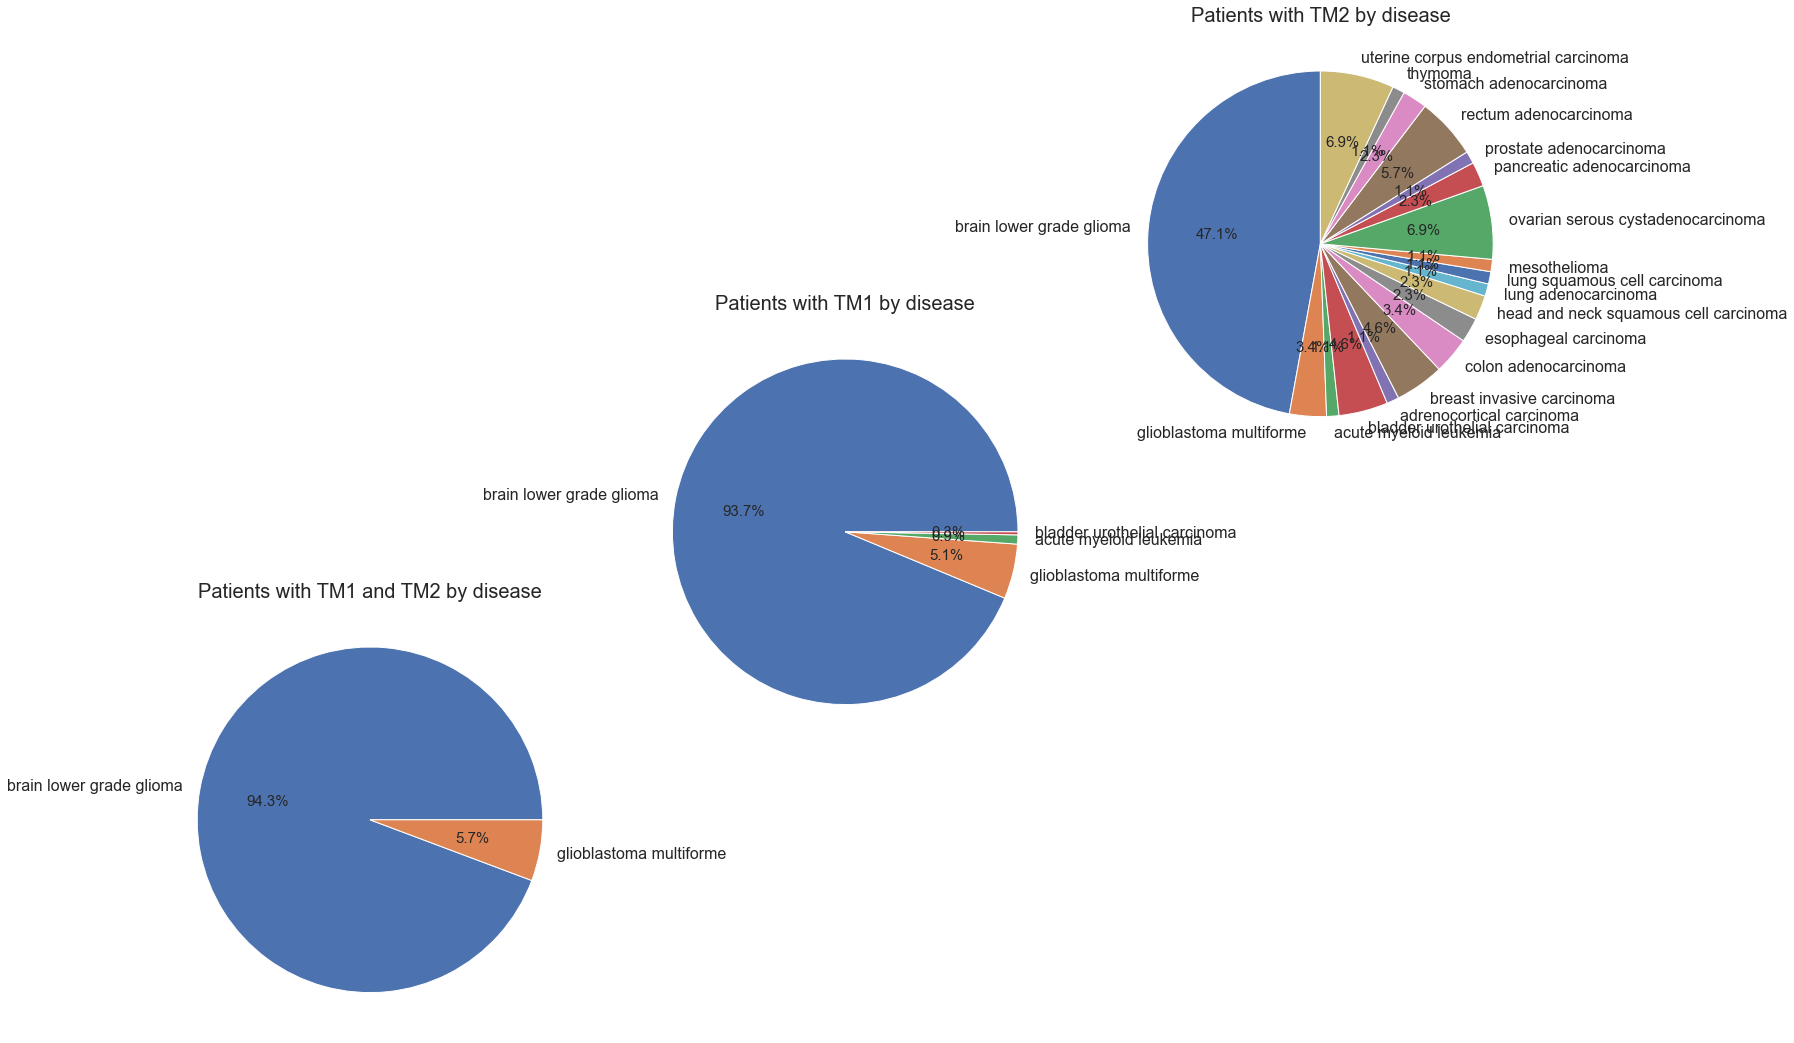

In [46]:
# put all countings side by side in single DataFrame (makes the plot use the same colors in all subplots)
df_concat = pd.concat([disease_distr_res_df, disease_distr_res_TM1_df, disease_distr_res_TM2_df], axis=1, copy=True)

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_axes([0, .15, .3, .9], aspect=1)
ax2 = fig.add_axes([.33, .35, .3, .9], aspect=1)
ax3 = fig.add_axes([.66, .55, .3, .9], aspect=1)
plt.rcParams['font.size'] = 15
plt.rc('xtick',labelsize=16)

# Donors of TM1 and TM2 (bottom left)
df_concat.drop(['TM2_DONORS', 'TM1_DONORS'], axis=1).dropna().plot(
    ax=ax1,
    kind='pie',
    y='TM1_TM2_DONORS',
    labels=df_concat.index.tolist(), 
    autopct='%1.1f%%',
    legend=None,
    title='Patients with TM1 and TM2 by disease'
)
# Donors of TM1 (middle)
df_concat.drop(['TM1_TM2_DONORS', 'TM2_DONORS'], axis=1).dropna().plot(
    ax=ax2,
    kind='pie',
    y='TM1_DONORS',
    labels=df_concat.index.tolist(), 
    autopct='%1.1f%%',
    legend=None,
    title='Patients with TM1 by disease'
)
# Donors of TM2 (top right)
df_concat.drop(['TM1_TM2_DONORS', 'TM1_DONORS'], axis=1).dropna().plot(
    ax=ax3,
    kind='pie',
    y='TM2_DONORS',
    labels=df_concat.index.tolist(), 
    autopct='%1.1f%%',
    title='Patients with TM2 by disease',
    legend=None,
    startangle=90
)
ax1.set(xlabel='', ylabel='')
ax1.title.set_size(20)
ax2.set(xlabel='', ylabel='')
ax2.title.set_size(20)
ax3.set(xlabel='', ylabel='')
ax3.title.set_size(20)

plt.show()

The presence of both TM1 and TM2 are good genetic markers for the diagnosis of brain lower grade glioma in the white ethnic group. This observation is confirmed by a study (reference at the end) published in Neuro-Oncology, which states: "The data indicate that IDH1 mutation combined with either TP53 mutation or total 1p/19q loss is a frequent and early change in the majority of oligodendroglial tumors, diffuse astrocytomas, anaplastic astrocytomas, and secondary glioblastomas  \[...]".

References:
- Ichimura, K., Pearson, D. M., Kocialkowski, S., Bäcklund, L. M., Chan, R., Jones, D. T., & Collins, V. P. (2009). IDH1 mutations are present in the majority of common adult gliomas but rare in primary glioblastomas. Neuro-oncology, 11(4), 341–347. https://doi.org/10.1215/15228517-2009-025